In [2]:
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import numpy

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
pe_file = '/g/data/r87/dbi599/CMIP5/CMIP/CCCma/CanESM2/piControl/r1i1p1/Oyr/pe/gn/v20120623/pe-zonal-sum_Ayr_CanESM2_piControl_r1i1p1_gn_201501-301012.nc'
pe_cube = iris.load_cube(pe_file, 'precipitation minus evaporation flux') 

In [4]:
lat_coord = pe_cube.coord('latitude').points
print(lat_coord)

[-87.86380134 -85.09652949 -82.31291545 -79.52560908 -76.73690218
 -73.94751766 -71.15775452 -68.36775861 -65.57760952 -62.7873543
 -59.99702261 -57.20663403 -54.41620203 -51.62573618 -48.83524347
 -46.04472914 -43.25419717 -40.46365068 -37.67309213 -34.8825235
 -32.09194639 -29.30136213 -26.51077183 -23.72017644 -20.92957676
 -18.13897349 -15.34836726 -12.55775862  -9.76714806  -6.97653606
  -4.18592304  -1.39530942   1.39530942   4.18592304   6.97653606
   9.76714806  12.55775862  15.34836726  18.13897349  20.92957676
  23.72017644  26.51077183  29.30136213  32.09194639  34.8825235
  37.67309213  40.46365068  43.25419717  46.04472914  48.83524347
  51.62573618  54.41620203  57.20663403  59.99702261  62.7873543
  65.57760952  68.36775861  71.15775452  73.94751766  76.73690218
  79.52560908  82.31291545  85.09652949  87.86380134]


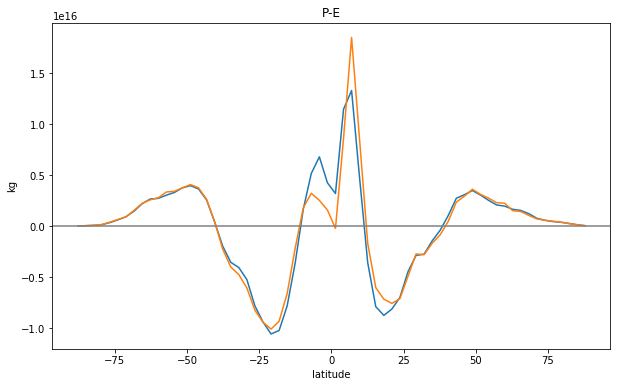

In [5]:
plt.figure(figsize=[10, 6])
iplt.plot(pe_cube[0, :])
iplt.plot(pe_cube[3, :])
plt.axhline(y=0.0, color='0.5', linestyle='-')
plt.xlabel('latitude')
plt.ylabel('kg')
plt.title('P-E')
plt.show()\

### Budget closure

In [97]:
pe_cube[0, :].data[pe_cube[0, :].data > 0].sum()

1.0415877e+17

In [98]:
pe_cube[0, :].data[pe_cube[0, :].data < 0].sum()

-1.0456659e+17

### Regional accumulation

In [106]:
def get_boundary_indexes(xintercept_indexes, lat_coord):
    """Find boundary indexes in x-intercepts"""
    
    sh_southern_boundary = None
    sh_northern_boundary = None
    for index in xintercept_indexes:
        lat = lat_coord[index]
        if (lat < -25) and (lat > -50) and not sh_southern_boundary:
            sh_southern_boundary = index
        if (lat < -7) and (lat > -25) and not sh_northern_boundary:
            sh_northern_boundary = index
        if sh_southern_boundary and sh_northern_boundary:
            break

    nh_southern_boundary = None
    nh_northern_boundary = None
    for index in reversed(xintercept_indexes):
        lat = lat_coord[index]
        if (lat > 25) and (lat < 50) and not nh_northern_boundary:
            nh_northern_boundary = index
        if (lat > 7) and (lat < 25) and not nh_southern_boundary:
            nh_southern_boundary = index
        if nh_southern_boundary and nh_northern_boundary:
            break

    assert (lat_coord[sh_southern_boundary] < -25) and (lat_coord[sh_southern_boundary] > -50)
    assert (lat_coord[sh_northern_boundary] < -7) and (lat_coord[sh_northern_boundary] > -25)
    assert (lat_coord[nh_southern_boundary] > 7) and (lat_coord[nh_southern_boundary] < 25)
    assert (lat_coord[nh_northern_boundary] > 25) and (lat_coord[nh_northern_boundary] < 50)
    
    return sh_southern_boundary, sh_northern_boundary, nh_southern_boundary, nh_northern_boundary


def get_regional_totals(pe_data, lat_coord):
    """Calculate the P-E zonally integrated regional totals.
    
    pe_data (numpy.array) - one dimensional (latitude) data array
    
    """

    pair_products = pe_data[0:-1] * pe_data[1:]
    xintercept_indexes = numpy.where(pair_products < 0)[0] + 1
    boundary_indexes = get_boundary_indexes(xintercept_indexes, lat_coord)
    
    sh_precip = pe_data[0:boundary_indexes[0]].sum()
    sh_evap = pe_data[boundary_indexes[0]:boundary_indexes[1]].sum()
    tropical_precip = pe_data[boundary_indexes[1]:boundary_indexes[2]].sum()
    nh_evap = pe_data[boundary_indexes[2]:boundary_indexes[3]].sum()
    nh_precip = pe_data[boundary_indexes[3]:].sum()

    return sh_precip, sh_evap, tropical_precip, nh_evap, nh_precip

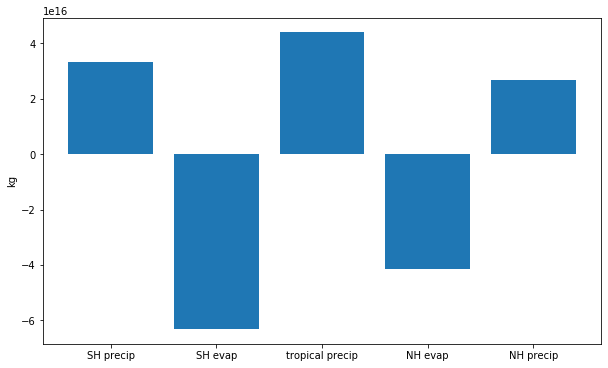

In [113]:
plt.figure(figsize=[10, 6])
yvals = get_regional_totals(pe_cube.data[0, :], lat_coord)
xvals = [0, 1, 2, 3, 4]
plt.bar(xvals, yvals)
plt.ylabel('kg')
plt.xticks(xvals, ['SH precip', 'SH evap', 'tropical precip', 'NH evap', 'NH precip'])
plt.show()

In [114]:
region_timeseries = numpy.apply_along_axis(get_regional_totals, 1, pe_cube.data, lat_coord)

In [115]:
region_timeseries.shape

(146, 5)

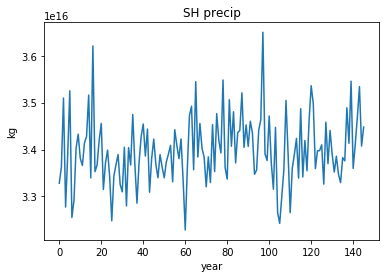

In [123]:
plt.plot(region_timeseries[:, 0])
plt.title('SH precip')
plt.ylabel('kg')
plt.xlabel('year')
plt.show()

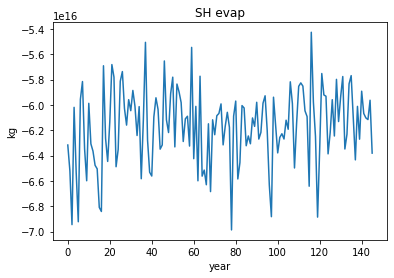

In [121]:
plt.plot(region_timeseries[:, 1])
plt.title('SH evap')
plt.ylabel('kg')
plt.xlabel('year')
plt.show()

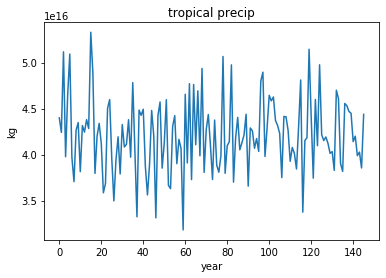

In [124]:
plt.plot(region_timeseries[:, 2])
plt.title('tropical precip')
plt.ylabel('kg')
plt.xlabel('year')
plt.show()

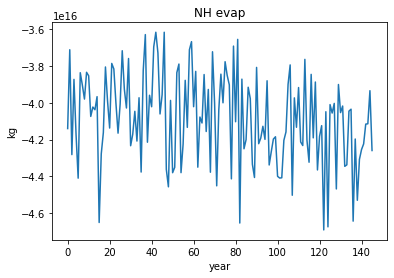

In [122]:
plt.plot(region_timeseries[:, 3])
plt.title('NH evap')
plt.ylabel('kg')
plt.xlabel('year')
plt.show()

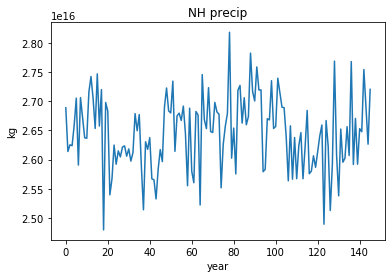

In [125]:
plt.plot(region_timeseries[:, 4])
plt.title('NH precip')
plt.ylabel('kg')
plt.xlabel('year')
plt.show()